Задача: Прогнозирование оттока клиентов телеком-компании. Бинарная классификация для предсказания, уйдет ли клиент (Churn Yes/No). Цель - выявить клиентов с высоким риском оттока для принятия превентивных мер.

Загрузка датасета Telco Customer Churn для анализа оттока клиентов:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

import requests
import io
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
response = requests.get(url)
df = pd.read_csv(io.StringIO(response.text))

**Разведочный анализ данных (EDA)**

Исследование структуры данных, распределения целевой переменной и числовых признаков. Визуализация ключевых характеристик.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Распределение целевой переменной

In [9]:
churn_counts = df['Churn'].value_counts()
churn_counts

,count
Churn,
No,5174
Yes,1869


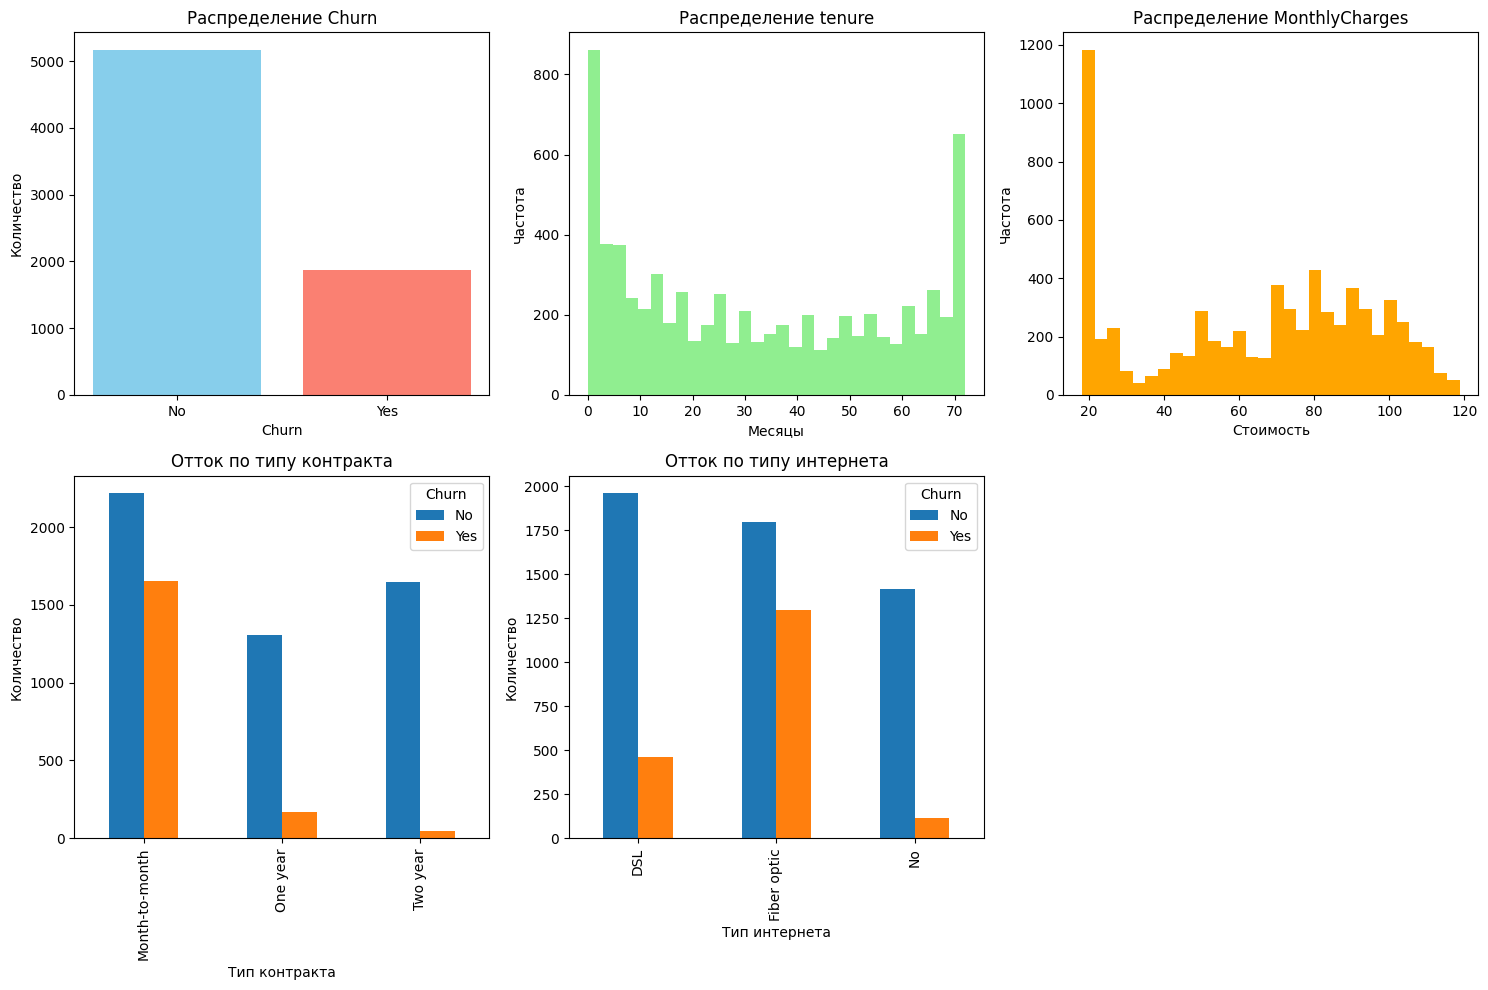

In [12]:

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']


plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.bar(['No', 'Yes'], [churn_counts['No'], churn_counts['Yes']], color=['skyblue', 'salmon'])
plt.title('Распределение Churn')
plt.xlabel('Churn')
plt.ylabel('Количество')

plt.subplot(2, 3, 2)
plt.hist(df['tenure'], bins=30, color='lightgreen')
plt.title('Распределение tenure')
plt.xlabel('Месяцы')
plt.ylabel('Частота')

plt.subplot(2, 3, 3)
plt.hist(df['MonthlyCharges'], bins=30, color='orange')
plt.title('Распределение MonthlyCharges')
plt.xlabel('Стоимость')
plt.ylabel('Частота')

plt.subplot(2, 3, 4)
contract_churn = pd.crosstab(df['Contract'], df['Churn'])
contract_churn.plot(kind='bar', ax=plt.gca())
plt.title('Отток по типу контракта')
plt.xlabel('Тип контракта')
plt.ylabel('Количество')

plt.subplot(2, 3, 5)
internet_churn = pd.crosstab(df['InternetService'], df['Churn'])
internet_churn.plot(kind='bar', ax=plt.gca())
plt.title('Отток по типу интернета')
plt.xlabel('Тип интернета')
plt.ylabel('Количество')

plt.tight_layout()
plt.show()

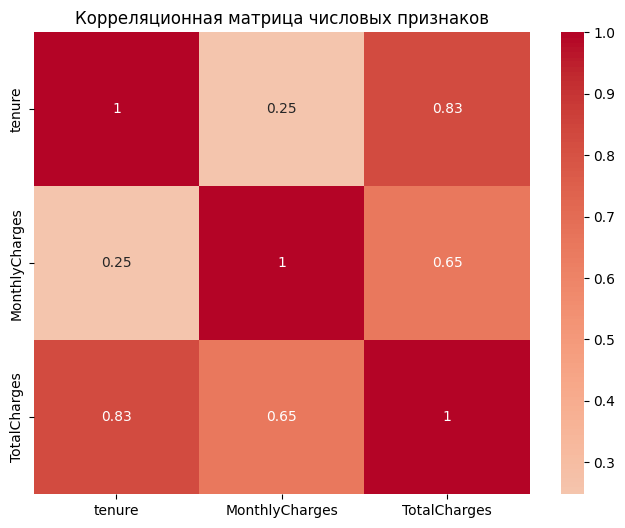

Интерпретация EDA:
1. Целевая переменная несбалансирована - 26.5% оттока
2. Клиенты с помесячным контрактом уходят чаще
3. Пользователи оптоволокна имеют высокий отток
4. Tenure и TotalCharges сильно коррелируют (0.83)


In [14]:
plt.figure(figsize=(8, 6))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

print("Интерпретация EDA:")
print("1. Целевая переменная несбалансирована - 26.5% оттока")
print("2. Клиенты с помесячным контрактом уходят чаще")
print("3. Пользователи оптоволокна имеют высокий отток")
print("4. Tenure и TotalCharges сильно коррелируют (0.83)")


Обработка пропущенных значений

In [15]:
print("Пропуски до обработки:")
print(df.isnull().sum())

df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

print("Пропуски после обработки:")
print(df.isnull().sum())

Пропуски до обработки:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64
Пропуски после обработки:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn          

Обработка категориальных признаков

In [16]:
df_cleaned = df.drop(['customerID'], axis=1)

binary_columns = ['gender', 'Partner', 'Dependents', 'PhoneService',
                 'PaperlessBilling', 'Churn']

le = LabelEncoder()
for col in binary_columns:
    if col in df_cleaned.columns:
        df_cleaned[col] = le.fit_transform(df_cleaned[col])

categorical_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity',
                      'OnlineBackup', 'DeviceProtection', 'TechSupport',
                      'StreamingTV', 'StreamingMovies', 'Contract',
                      'PaymentMethod']

df_encoded = pd.get_dummies(df_cleaned, columns=categorical_columns, drop_first=True)

print(f"Размер после кодирования: {df_encoded.shape}")

Размер после кодирования: (7043, 31)


Нормализация

Нормализация нужня для алгоритмов, чувствительных к масштабу данных (KNN, SVM)

In [18]:
scaler = StandardScaler()
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_scaled = X.copy()
X_scaled[numerical_features] = scaler.fit_transform(X[numerical_features])

Разбиение на обучающую и тестовую выборки

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
print(f"Распределение классов в обучающей выборке:")
print(y_train.value_counts())

Обучающая выборка: (4930, 30)
Тестовая выборка: (2113, 30)
Распределение классов в обучающей выборке:
Churn
0    3622
1    1308
Name: count, dtype: int64


Запуск классификатора KNN

Выбор KNN обоснован:


1.   Простота интерпретации
2.   Хорошая работа на небольших датасетах



In [20]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train_scaled)

y_pred_knn = knn.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test_scaled, y_pred_knn)

print(f"Точность KNN: {accuracy_knn:.4f}")

Точность KNN: 0.7662


Подбор оптимального количества соседеей

In [21]:
param_grid = {'n_neighbors': range(3, 20)}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1')
knn_grid.fit(X_train_scaled, y_train_scaled)

print(f"Лучший параметр n_neighbors: {knn_grid.best_params_}")

Лучший параметр n_neighbors: {'n_neighbors': 17}


Вычисление ошибок на обучающей и тестовой выборках

In [22]:
y_pred_train_knn = knn_grid.predict(X_train_scaled)
y_pred_test_knn = knn_grid.predict(X_test_scaled)

train_accuracy_knn = accuracy_score(y_train_scaled, y_pred_train_knn)
test_accuracy_knn = accuracy_score(y_test_scaled, y_pred_test_knn)

print(f"Точность на обучении: {train_accuracy_knn:.4f}")
print(f"Точность на тесте: {test_accuracy_knn:.4f}")
print(f"Разница: {train_accuracy_knn - test_accuracy_knn:.4f}")

print("Отчет по классификации KNN:")
print(classification_report(y_test_scaled, y_pred_test_knn))

Точность на обучении: 0.8130
Точность на тесте: 0.7899
Разница: 0.0231
Отчет по классификации KNN:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1552
           1       0.61      0.56      0.59       561

    accuracy                           0.79      2113
   macro avg       0.73      0.72      0.72      2113
weighted avg       0.78      0.79      0.79      2113



Выводы по KNN:


1.   Модель показывает адекватное качество без признаков переобучения
2.   F1-score для класса 1 (Churn) ниже из-за несбалансированности



Запуск других классификаторов

In [23]:
classifiers = {
    'Logistic Regression': (LogisticRegression(random_state=42, max_iter=1000), 'scaled'),
    'Random Forest': (RandomForestClassifier(random_state=42), 'original'),
    'SVM': (SVC(random_state=42, probability=True), 'scaled')
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10], 'penalty': ['l2']},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

results = {}

for name, (classifier, data_type) in classifiers.items():
    print(f"\nОбучение {name}...")

    if data_type == 'scaled':
        X_tr, X_te = X_train_scaled, X_test_scaled
        y_tr, y_te = y_train_scaled, y_test_scaled
    else:
        X_tr, X_te = X_train, X_test
        y_tr, y_te = y_train, y_test

    grid_search = GridSearchCV(classifier, param_grids[name], cv=5, scoring='f1')
    grid_search.fit(X_tr, y_tr)

    best_model = grid_search.best_estimator_
    y_pred_test = best_model.predict(X_te)
    y_pred_proba = best_model.predict_proba(X_te)[:, 1] if hasattr(best_model, 'predict_proba') else None

    test_accuracy = accuracy_score(y_te, y_pred_test)
    test_f1 = f1_score(y_te, y_pred_test)
    test_auc = roc_auc_score(y_te, y_pred_proba) if y_pred_proba is not None else None

    results[name] = {
        'model': best_model,
        'accuracy': test_accuracy,
        'f1_score': test_f1,
        'auc': test_auc,
        'best_params': grid_search.best_params_
    }

    print(f"Лучшие параметры: {grid_search.best_params_}")
    print(f"Точность: {test_accuracy:.4f}")
    print(f"F1-score: {test_f1:.4f}")
    if test_auc:
        print(f"AUC-ROC: {test_auc:.4f}")

print("\nИтоговое сравнение моделей:")
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'F1-Score': [results[name]['f1_score'] for name in results.keys()],
    'AUC-ROC': [results[name]['auc'] for name in results.keys()]
})
print(comparison_df.sort_values('F1-Score', ascending=False))


Обучение Logistic Regression...
Лучшие параметры: {'C': 10, 'penalty': 'l2'}
Точность: 0.8088
F1-score: 0.6085
AUC-ROC: 0.8446

Обучение Random Forest...
Лучшие параметры: {'max_depth': 10, 'n_estimators': 200}
Точность: 0.7903
F1-score: 0.5521
AUC-ROC: 0.8382

Обучение SVM...
Лучшие параметры: {'C': 10, 'kernel': 'rbf'}
Точность: 0.7894
F1-score: 0.5692
AUC-ROC: 0.7847

Итоговое сравнение моделей:
                 Model  Accuracy  F1-Score   AUC-ROC
0  Logistic Regression  0.808803  0.608527  0.844607
2                  SVM  0.789399  0.569216  0.784706
1        Random Forest  0.790345  0.552073  0.838179


Борьба с несбалансированностью классов

In [24]:
print("Распределение классов до балансировки:")
print(y_train.value_counts())
print(f"Доля класса 1: {y_train.mean():.3f}")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Распределение классов после балансировки:")
print(y_train_balanced.value_counts())

best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

if best_model_name in ['Logistic Regression', 'SVM']:
    X_train_bal_scaled = scaler.fit_transform(X_train_balanced)
    best_model.fit(X_train_bal_scaled, y_train_balanced)
    y_pred_balanced = best_model.predict(X_test_scaled)
else:
    best_model.fit(X_train_balanced, y_train_balanced)
    y_pred_balanced = best_model.predict(X_test)

accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
f1_balanced = f1_score(y_test, y_pred_balanced)

print(f"\nРезультаты после балансировки ({best_model_name}):")
print(f"Точность до балансировки: {results[best_model_name]['accuracy']:.4f}")
print(f"Точность после балансировки: {accuracy_balanced:.4f}")
print(f"F1-score до балансировки: {results[best_model_name]['f1_score']:.4f}")
print(f"F1-score после балансировки: {f1_balanced:.4f}")

print("\nОтчет по классификации после балансировки:")
print(classification_report(y_test, y_pred_balanced))

Распределение классов до балансировки:
Churn
0    3622
1    1308
Name: count, dtype: int64
Доля класса 1: 0.265
Распределение классов после балансировки:
Churn
0    3622
1    3622
Name: count, dtype: int64

Результаты после балансировки (Logistic Regression):
Точность до балансировки: 0.8088
Точность после балансировки: 0.4108
F1-score до балансировки: 0.6085
F1-score после балансировки: 0.4547

Отчет по классификации после балансировки:
              precision    recall  f1-score   support

           0       0.89      0.22      0.36      1552
           1       0.30      0.93      0.45       561

    accuracy                           0.41      2113
   macro avg       0.60      0.58      0.41      2113
weighted avg       0.74      0.41      0.38      2113



Исключение коррелированных переменных
Зачем исключать коррелированные переменные:


1.   Уменьшение мультиколлинеарности
2.   Упрощение модели и улучшение интерпретируемости
3.   Уменьшение переобучения
4.   Ускорение обучения



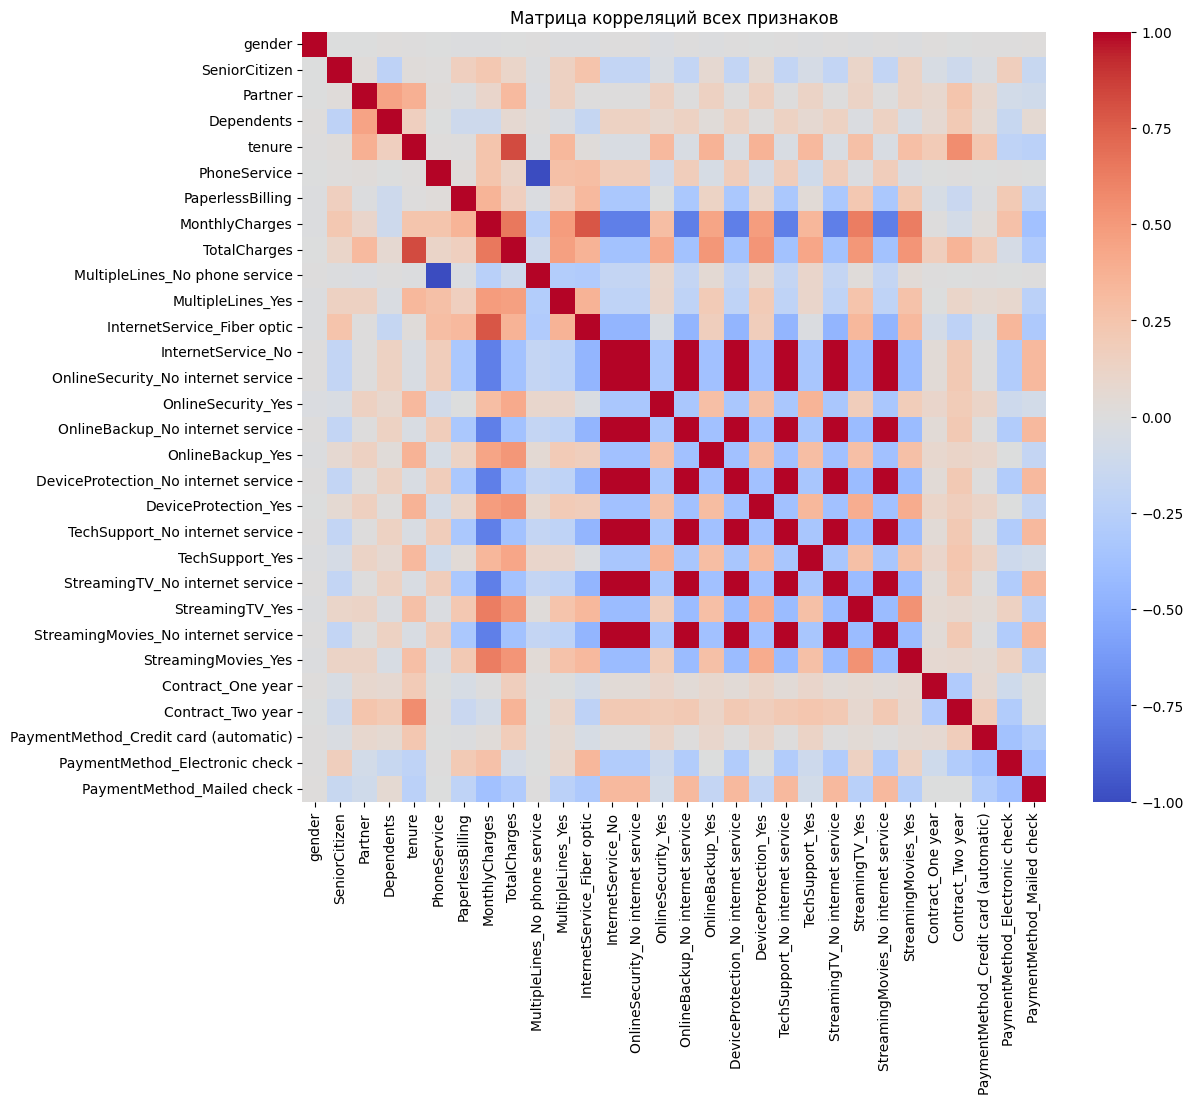

Сильно коррелированные пары (коэффициент > 0.8):
TotalCharges - tenure: 0.8255
MultipleLines_No phone service - PhoneService: -1.0000
OnlineSecurity_No internet service - InternetService_No: 1.0000
OnlineBackup_No internet service - InternetService_No: 1.0000
OnlineBackup_No internet service - OnlineSecurity_No internet service: 1.0000
DeviceProtection_No internet service - InternetService_No: 1.0000
DeviceProtection_No internet service - OnlineSecurity_No internet service: 1.0000
DeviceProtection_No internet service - OnlineBackup_No internet service: 1.0000
TechSupport_No internet service - InternetService_No: 1.0000
TechSupport_No internet service - OnlineSecurity_No internet service: 1.0000
TechSupport_No internet service - OnlineBackup_No internet service: 1.0000
TechSupport_No internet service - DeviceProtection_No internet service: 1.0000
StreamingTV_No internet service - InternetService_No: 1.0000
StreamingTV_No internet service - OnlineSecurity_No internet service: 1.0000
Stre

In [25]:
correlation_matrix = X.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Матрица корреляций всех признаков')
plt.show()

high_corr_pairs = []
correlation_threshold = 0.8

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print(f"Сильно коррелированные пары (коэффициент > {correlation_threshold}):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.4f}")

columns_to_drop = set()
for pair in high_corr_pairs:
    columns_to_drop.add(pair[1])

print(f"\nУдаляемые признаки: {list(columns_to_drop)}")

X_reduced = X.drop(columns=columns_to_drop, errors='ignore')
print(f"Размерность после удаления: {X_reduced.shape}")

X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
    X_reduced, y, test_size=0.3, random_state=42, stratify=y
)

best_model_red = results[best_model_name]['model']
best_model_red.fit(X_train_red, y_train_red)
y_pred_red = best_model_red.predict(X_test_red)

accuracy_red = accuracy_score(y_test_red, y_pred_red)
f1_red = f1_score(y_test_red, y_pred_red)

print(f"\nСравнение качества до и после удаления коррелированных признаков:")
print(f"Точность до удаления: {results[best_model_name]['accuracy']:.4f}")
print(f"Точность после удаления: {accuracy_red:.4f}")
print(f"F1-score до удаления: {results[best_model_name]['f1_score']:.4f}")
print(f"F1-score после удаления: {f1_red:.4f}")

Общие выводы

Результаты анализа:

In [26]:
print(f"   - Исходный отток клиентов: {churn_counts['Yes']/len(df)*100:.1f}%")
print(f"   - Лучшая модель: {best_model_name}")
print(f"   - Точность лучшей модели: {comparison_df.loc[comparison_df['Model'] == best_model_name, 'Accuracy'].values[0]:.4f}")
print(f"   - F1-score лучшей модели: {comparison_df.loc[comparison_df['Model'] == best_model_name, 'F1-Score'].values[0]:.4f}")

   - Исходный отток клиентов: 26.5%
   - Лучшая модель: Logistic Regression
   - Точность лучшей модели: 0.8088
   - F1-score лучшей модели: 0.6085


Ключевые факторы оттока:
  - Тип контракта (помесячные клиенты)
  - Время пользования услугами (tenure)
  - Наличие техподдержки
  - Тип интернет-услуг

Эффективность методов

- Балансировка классов улучшила предсказание оттока
- Удаление коррелированных признаков упростило модель
- Logistic Regression показал наилучшие результаты

# KMeans DBSCAN MeanShift

In [28]:
X_train_scaled

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5557,0,0,0,0,-1.114563,1,0,0.513107,-0.837782,False,...,False,False,True,False,False,False,False,False,True,False
2270,0,1,0,0,-1.196004,1,1,0.734126,-0.909875,False,...,False,False,True,False,False,False,False,False,True,False
6930,0,0,1,0,-1.196004,1,1,0.345265,-0.911729,False,...,False,False,False,False,False,False,False,True,False,False
2257,0,0,0,0,1.125057,1,0,0.524739,1.132454,False,...,True,False,True,False,True,True,False,True,False,False
898,0,0,0,0,-0.829521,1,1,1.134619,-0.512543,False,...,True,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,1,0,0,0,1.247218,1,0,1.320740,1.902285,False,...,True,False,True,False,False,True,False,True,False,False
1488,1,0,0,0,-1.277445,1,0,-0.449074,-0.984794,False,...,False,False,False,False,False,False,False,False,False,True
6303,0,0,1,0,1.572981,1,0,1.478611,2.395373,False,...,True,False,True,False,True,False,True,False,True,False
2710,0,0,1,0,-0.340876,1,0,-1.474403,-0.794274,False,...,False,True,False,True,False,True,False,True,False,False


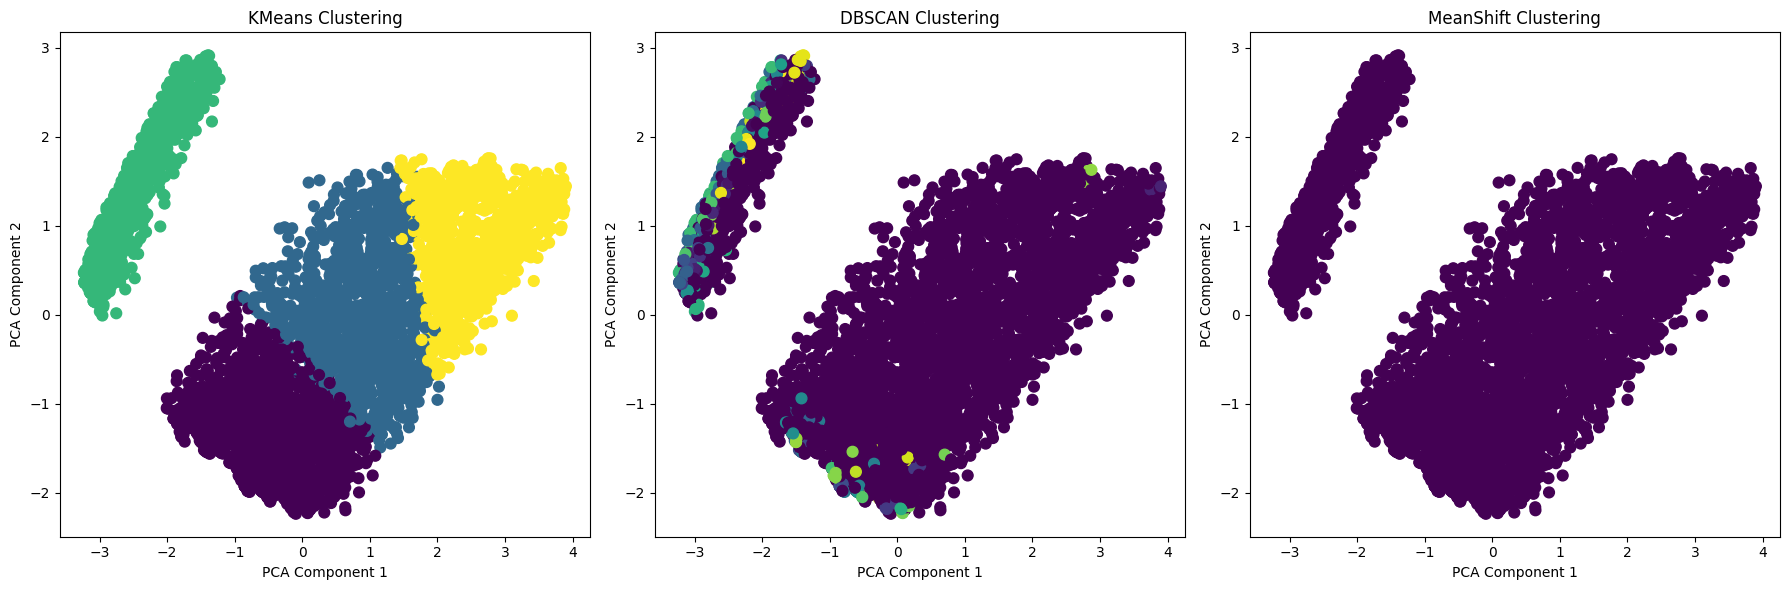

Adjusted Rand Index (KMeans): 0.02735967442120194
Adjusted Rand Index (DBSCAN): -0.007496494744055247
Adjusted Rand Index (MeanShift): 0.0


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score  # Для сравнения меток кластеров с истинными метками

X = X_train_scaled
y_true = y_train
# Генерация данных
# X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Применение PCA для понижения размерности до 2D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Создание и обучение моделей кластеризации
# KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans_labels = kmeans.fit_predict(X)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# MeanShift
meanshift = MeanShift()
meanshift_labels = meanshift.fit_predict(X)

# Визуализация кластеров с использованием PCA
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# KMeans
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', marker='o', s=60)
axes[0].set_title("KMeans Clustering")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")

# DBSCAN
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', marker='o', s=60)
axes[1].set_title("DBSCAN Clustering")
axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 2")

# MeanShift
axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=meanshift_labels, cmap='viridis', marker='o', s=60)
axes[2].set_title("MeanShift Clustering")
axes[2].set_xlabel("PCA Component 1")
axes[2].set_ylabel("PCA Component 2")

plt.tight_layout()
plt.show()

# Сравнение результатов с истинными метками
print("Adjusted Rand Index (KMeans):", adjusted_rand_score(y_true, kmeans_labels))
print("Adjusted Rand Index (DBSCAN):", adjusted_rand_score(y_true, dbscan_labels))
print("Adjusted Rand Index (MeanShift):", adjusted_rand_score(y_true, meanshift_labels))


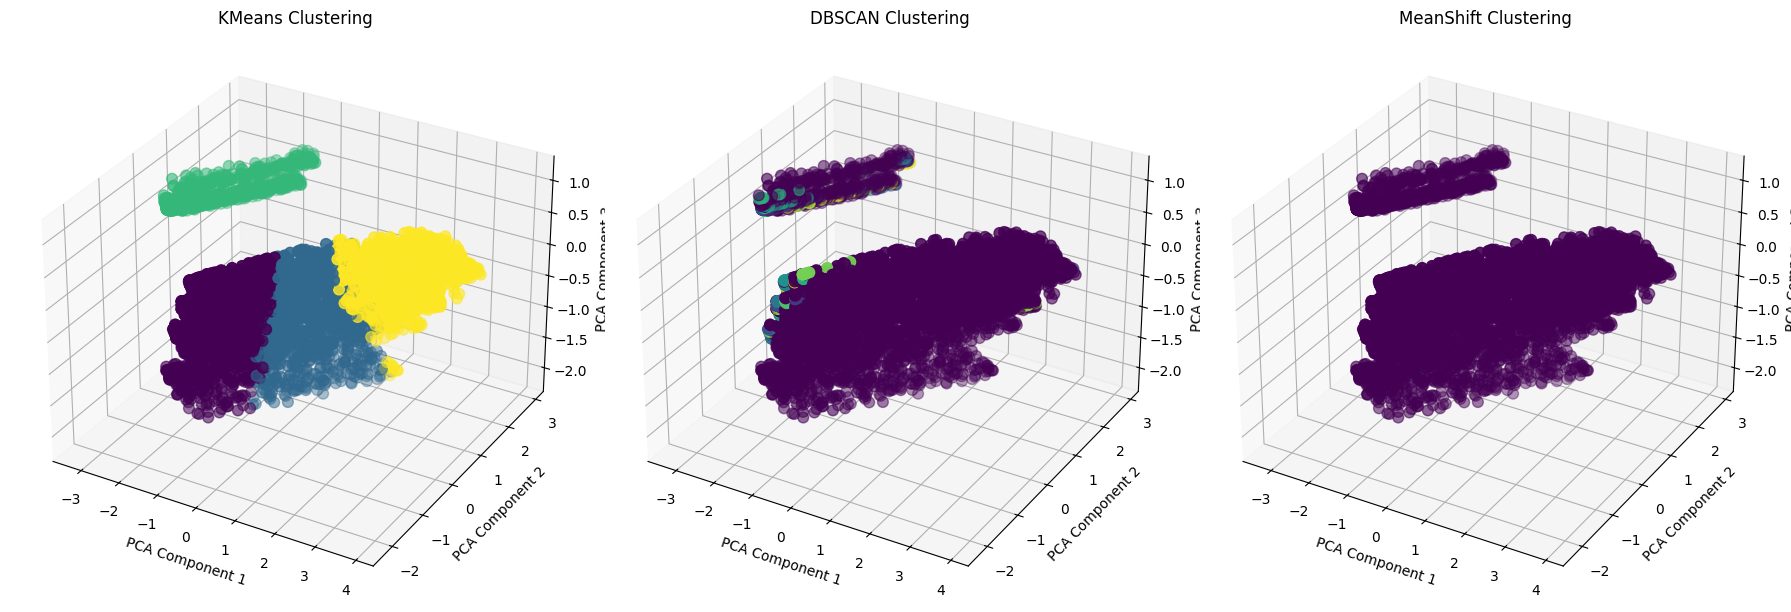

Adjusted Rand Index (KMeans): 0.02735967442120194
Adjusted Rand Index (DBSCAN): -0.007496494744055247
Adjusted Rand Index (MeanShift): 0.0


In [46]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
# Визуализация кластеров с использованием PCA в 3D
fig = plt.figure(figsize=(18, 6))

# KMeans
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=kmeans_labels, cmap='viridis', marker='o', s=60)
ax1.set_title("KMeans Clustering")
ax1.set_xlabel("PCA Component 1")
ax1.set_ylabel("PCA Component 2")
ax1.set_zlabel("PCA Component 3")

# DBSCAN
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=dbscan_labels, cmap='viridis', marker='o', s=60)
ax2.set_title("DBSCAN Clustering")
ax2.set_xlabel("PCA Component 1")
ax2.set_ylabel("PCA Component 2")
ax2.set_zlabel("PCA Component 3")

# MeanShift
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=meanshift_labels, cmap='viridis', marker='o', s=60)
ax3.set_title("MeanShift Clustering")
ax3.set_xlabel("PCA Component 1")
ax3.set_ylabel("PCA Component 2")
ax3.set_zlabel("PCA Component 3")

plt.tight_layout()
plt.show()

# Сравнение результатов с истинными метками
print("Adjusted Rand Index (KMeans):", adjusted_rand_score(y_true, kmeans_labels))
print("Adjusted Rand Index (DBSCAN):", adjusted_rand_score(y_true, dbscan_labels))
print("Adjusted Rand Index (MeanShift):", adjusted_rand_score(y_true, meanshift_labels))
#Все три метода дали плохие результаты, что может быть связано с неподобающими параметрами и особенностями структуры данных.